## Warning: This code is meant for tutorial purposes do not use it for recommendations

## Importing libraries necessary for the code

In [3]:
# import needed libraries
import pandas as pd
import os
import numpy as np
import random
import pickle as pkl
import nltk
import string
from nltk.corpus import stopwords
from autocorrect import Speller
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


## Data Collection
- OpenFDA is a public facing repository of FDA datasets.
- These datasets are released to comply with the freedom of information act. They cannot be used for recommendations.
- Reading in text from the OpenFDA website. https://open.fda.gov/data/downloads/ 
- You can find other sets if you'd like to experiement with this data.
- More features can be collected and engineered from other sets within OpenFDA

In [4]:
#Read in the foi text set for inputs
df_text=pd.read_csv('../Data/foitext.txt',sep='|', encoding = "ISO-8859-1")

In [5]:
#Read in the patient set for labels
df_patient=pd.read_csv('../Data/patient.txt',sep='|', encoding = "ISO-8859-1")

## Data Exploration and Doamin Knowledge:
- Most of the Research and Exploratory Data Analysis was performed prior to making this notebook.
- It was detemrined which categories have an absence of information and which ones denote a life threatening or death related event. 
- This specific task will be using machine learning to determine whether or not a device's adverse event will be cause death or be life threatening. 
- If infomration is unknown, it is important to denote that it is niether a 1 or 0

In [6]:
#function that takes in labels and turns them into life altering and non life altering
#The unkown values are replaced with nulls and taken from the set overall
def threatening_or_death(entries):
    threatening_or_death=[]
    for i in entries:
        if 'L' in str(i) or 'D' in str(i):
            threatening_or_death.append(1)
        elif '*' in str(i) or 'U' in str(i) or 'I' in str(i) or 'A' in str(i):
            threatening_or_death.append(np.nan)
        else:
            threatening_or_death.append(0)
    return threatening_or_death

## Data Preparation:
- Each text entry is associated with an appropriate label. 
- The data frames are merged on the unique MDR_REPORT_KEY.
- There are few life threatening events compared to non-life threatening events thus, to balance this set, we need to select a random number of non-life threatening events equal to the number of life threatening events.


In [7]:
#Merge the dataset together
result = pd.merge(df_text, df_patient, on="MDR_REPORT_KEY",how='inner')


In [8]:
#Function separate the data into life threatening and non-life threatening
def extract_negative(result,life_threatening):
    t_or_d=threatening_or_death(result.SEQUENCE_NUMBER_OUTCOME)
    result['life_threatening_or_death']=t_or_d
    negative_df=result[result['life_threatening_or_death']==life_threatening]
    return negative_df

In [9]:
#Extract a number of random samples from the negative dataset that match the number of positive samples
def prep_dataset(result):
    set_of_MDRs=random.sample(range(1, len(result.MDR_REPORT_KEY)), 18370)
    set_of_keys=result.MDR_REPORT_KEY.iloc[set_of_MDRs]
    same_sample_df=result[result.MDR_REPORT_KEY.isin(set_of_keys)]
    
    return same_sample_df

In [10]:
#Recombine the negative and psotive sets, then shuffle the values.
def combine_dataset(positive,negative):
    evened_df=pd.concat([positive,negative])
    evened_df=evened_df.sample(frac = 1)
    return evened_df

In [11]:
#Execute the functions created
positive=extract_negative(result,1)
negative=extract_negative(result,0)
random_negative_sample=prep_dataset(negative)
finalized_set=combine_dataset(positive,random_negative_sample)

In [19]:
finalized_set.shape

(53620, 11)

## Text Cleaning:
- Establish the lists and instantiate the proper text cleaning objects.
- This cleaning is how you can add your sepcific industry flavor to your Natual Langauge Processing
- There are automated tokenizers, however this is how you cater your text to your data.
- These are just some boiler plate text cleaning methods for demonstration.

In [20]:
#instantiate the needed items for our text cleaning object
#lemmatizer instatiation
lemma=WordNetLemmatizer()
#Download the nltk modules
nltk.download("punkt")
nltk.download('stopwords')
#prep the punctuation list
punct_list=string.punctuation
#prep the stopword list
stop_words=stopwords.words('english')
#instantiate the spell checker
check=Speller(lang='en')
#expand the punctuation list
punct_list=punct_list+'¿1234567890'

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\baker\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\baker\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**These are the base functions for cleaning text. You can edit these to more properly suit your text.**

Most of these functions follow the simple algorothm outline:
- Split each text entry into words singular words
- Apply the proper cleaning method to each word
- Rejoin the line of text

To decrease the processing time for spelling: 
- A unique word list is created
- The autocorrect library processes each unique word
- A dictionary is created where the original word is the key and the new word is the value
- This dictionary is then saved

This spelling method greatly decreases the text cleaning run time. 

*To further increase preprocessing speed, one can create a separate list of unique words not found in the English dictionary and only construct the respelling dictionary with those.*

In [22]:
class Text_Preprocessing:
    
    #gather the necessary variables to perform the text cleaning
    def __init__(self,punct_list,stop_word_list,lemmatizer):
        self.punct_list=punct_list
        self.stop_word_list=stop_word_list
        self.lemma=lemma
        self.check=check
    
    #delete the punctuation
    def punctuation(self,text):
        no_punct=[i.translate(str.maketrans(' ',' ',self.punct_list)) for i in text.lower().split(' ')]
        return ' '.join(no_punct)
    
    #delete the stopwords
    def stop_words(self,text):
        no_stop=[i for i in text.lower().split(' ') if i not in self.stop_word_list]
        return ' '.join(no_stop)
    
    #receive a unique set of all words from teh text
    def get_word_set(self,full_text):
        word_list=[]
        for i in full_text:
            for j in i.split(' '):
                word_list.append(j)
        return set(word_list)
    
    #create a mapping of mispelled words to properly spelled words
    def create_spelling_dict(self,word_list):
        spelling_dict={}
        p=0
        for i in finalized_word_list:
            spelling_dict[i]=tp.check(i)
            if p%1000==0:
                print(p)
            p+=1
        f=open('spelling_dict.pkl','wb')
        pkl.dump(spelling_dict,f)
        f.close()
        return spelling_dict
    
    
    #respell the text using the mapping
    def spelling(self,i):
        rf=open('spelling_dict.pkl','rb')
        spelling_dict_t=pkl.load(rf)
        rf.close()
        
        properly_spelled=[]
        for j in i.split(' '):
            if j in spelling_dict_t.keys():
                properly_spelled.append(spelling_dict_t[j])
            else:
                properly_spelled.append(j)
        return ' '.join(properly_spelled)
    
    #lemmatize the data one word at a time
    def lemmatize(self,text):
        lemmatized_text=[self.lemma.lemmatize(i) for i in text.lower().split(' ')]
        return ' '.join(lemmatized_text)

## Text Preparation Outline:
- Punctuation is expelled
- Stop words are extracted
- Respelling
- Lemmatization

*If you would like to take this further, you can add a translation function to ensure all words are in one langauge.*

In [23]:
#Extract the text field from the set
full_text=finalized_set.FOI_TEXT

In [24]:
# instantiate the text cleaning object
tp=Text_Preprocessing(punct_list,stop_words,lemma)

In [25]:
#preprocess the text one line at a time
finalized_text=[]
p=0
for i in full_text:
    no_punct=tp.punctuation(i)
    no_stop=tp.stop_words(no_punct)
    spelled=tp.spelling(no_stop)
    lemmatized_text=tp.lemmatize(spelled)
    finalized_text.append(lemmatized_text)
    if p%1000==0:
        print(p)
    p+=1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000


## Saving

In [36]:
f=open('finalized_text.pkl','wb')
pkl.dump(finalized_text,f)
f.close()

In [23]:
rf=open('finalized_text.pkl','rb')
lemmatized_text=pkl.load(rf)
rf.close()

## Vectorization
As a demonstration, the tfidf vectorizer is used with this text. <br/>
This vectorizer is simple and adds a great deal of transparency to your model. <br/>
This code takes a set of tokenized text, and transforms it into a pandas data set.


If you'd like to check out some more black box vectorizers look into these
- https://www.machinelearningplus.com/gensim-tutorial/
- https://huggingface.co/
- https://towardsdatascience.com/long-short-term-memory-lstm-in-keras-2b5749e953ac

Another tutorial can be made on these more advanced black-box transformer techniques.

In [27]:
#vectorize the text using tfidf vectorizer
tfidf=TfidfVectorizer(ngram_range=(1,1),stop_words={'english'})
vectorized_text=tfidf.fit_transform(finalized_text)
dense_matrix=vectorized_text.todense()
features=tfidf.get_feature_names()
text_entries=pd.DataFrame(dense_matrix)
text_entries.columns=features

In [50]:
f=open('tfidf_model.pkl','wb')
pkl.dump(tfidf,f)
f.close()

## Model Creation:
- This set was too large to perform k-fold cross validation and parameter optimization, but if you have the resources I'd recommend performing both. 
- The models selected are excellent in dealing with data that has many columns, and provides decent transparency. 
- The RandomForest model demonstrates that black box methods may be more powerful, but will have this level of uncertainty associated with them compared to the first 3.
- Models are saved after the training

**Models tested:**
- Logistic Regression
- Naive bayes
- SVM
- Random Forest

Test other algorithms to see if you can beat these scores. You can also analyze these results with other metrics.

In [29]:
#Separate the sets into inputs and labels
X=text_entries
y=finalized_set['life_threatening_or_death']

In [30]:
#split the data into testing and training sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [31]:
X_train.shape

(42896, 19964)

In [40]:
# train and assess the accuracy of the logistic regression model
lr=LogisticRegression()
lr_fit=lr.fit(X_train,y_train)
lr_pred=lr.predict(X_test)
accuracy_score(lr_pred,y_test)

C:\Users\baker\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9212047743379336

In [41]:
f=open('logistic_regression.pkl','wb')
pkl.dump(lr_fit,f)
f.close()

## Result Analysis: 
- The coefficients and features of a model are placed into a pandas dataframe 
- The dataframe is sorted by coefficient value
- The top 10 words are chosen and plotted

In [60]:
#creating the coefficient matrix for model analysis
def create_coef_mat(fit,file_name):
    coef=lr_fit.coef_[0]
    coefficients=pd.DataFrame()
    coefficients['features']=X.columns
    coefficients['coef']=[np.abs(i) for i in coef]
    coefficients.set_index('features',inplace=True)

    f=open(file_name,'wb')
    pkl.dump(coefficients,f)
    f.close()
    return coefficients

In [61]:
#executing the fucntion
coefficients=create_coef_mat(lr_fit,'coef_mat.pkl')

In [62]:
from sklearn.metrics import confusion_matrix
confusion_matrix(lr_pred,y_test)

array([[6615,  399],
       [ 446, 3264]], dtype=int64)

## Findings:
- Most of the top words tend to be associated with passing, but some interesting potential areas of risk include filters and perforation.

- More analysis needs to be done to discover what exactly "expired" to lead to danger.

- We can further use these results to tune our text cleaning

- A stop word made it in, so further tuning is needed

In [63]:
#look at the variables that have th most impact
coefficients.sort_values('coef',ascending=False)

coef
features               
death         10.606214
expired        7.346640
died           6.736621
away           6.066951
fda            5.895758
...                 ...
eburnated      0.000000
ionization     0.000000
sorority       0.000000
tse            0.000000
overdrainage   0.000000

[19964 rows x 1 columns]

In [64]:
#plot the top coefficients
coefficients.sort_values('coef',ascending=False)[0:10].plot(kind='bar')

<AxesSubplot:xlabel='features'>

In [52]:
# train and assess the accuracy of the naive bayes model
gb=GaussianNB()
gb_fit=gb.fit(X_train,y_train)
gb_preds=gb_fit.predict(X_test)
accuracy_score(gb_preds,y_test)

0.7866467735919433

In [58]:
coefficients_gb=create_coef_mat(gb_fit,'coef_mat_gb.pkl')

<AxesSubplot:xlabel='features'>

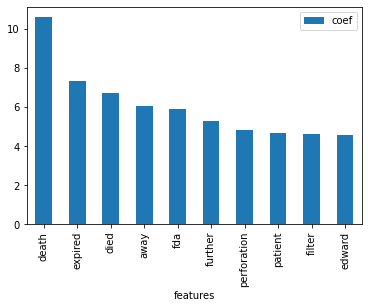

In [59]:
#plot the top coefficients
coefficients_gb.sort_values('coef',ascending=False)[0:10].plot(kind='bar')

In [ ]:
f=open('gaussian_model.pkl','wb')
pkl.dump(gb_fit,f)
f.close()

In [ ]:
# train and assess the accuracy of the svm model
svm=SVC(kernel='linear')
sv_fit=svm.fit(X_test,y_test)
sv_preds=sv_fit.predict(X_test)
accuracy_score(sv_preds,y_test)

In [ ]:
f=open('svm.pkl','wb')
pkl.dump(sv_fit,f)
f.close()

In [ ]:
# train and assess the accuracy of the random forest model
rf=RandomForestClassifier()
rf_fit=rf.fit(X_train,y_train)
rf_pred=rf_fit.predict(X_test
accuracy_score(rf_pred,y_test)

In [ ]:
f=open('random_forest.pkl','wb')
pkl.dump(rf_fit,f)
f.close()